In [2]:
import pytraj as pt
import pytraj.utils.progress
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import collections
import sys
import gc
import os
import sklearn as skl
from sklearn import decomposition
from sklearn import metrics
from sklearn import discriminant_analysis
import tqdm
import nglview as nv
import ipywidgets
import copy
import cPickle

# Introduction
This notebook will load each simulation trajectory and compute phi and psi backbone
dihedrals for each residue.

The raw trajectory data itself is not included in this git repository due to file size considerations
it will be made available for download in the future (the README will be updated accordingly when it
is available).

The data generated by this notebook is all that will be needed to run subsequent analysis and visualizations.

# Load trajectory data

This cell loads each trajectory as a pytraj 'itertraj' object (a pointer to the data on disk)
these objects are stored in a dictionary for ease of access.

In [3]:
trajBaseDir='trajData/Full_Model'
topFileName='topology.stripped.nochamber.parm7'
trajFileName='strippedTraj.dcd'

systems=["yoda0","yoda1","dooku1"]
nReps=4
reps=['replica_%02g'%iRep for iRep in np.arange(nReps)]

sysDirStr='wt_short_%s'

trajDict={}
for system in systems:
    sysDir='/'.join([trajBaseDir,sysDirStr%system])
    topFilePath='/'.join([sysDir,topFileName])
    for rep in reps:
        trajKey='.'.join([system,rep])
        print '--- loading %s ---'%trajKey
        trajDir='/'.join([sysDir,rep])
        trajFilePath='/'.join([trajDir,trajFileName])
        trajDict[trajKey]=pt.iterload(trajFilePath,top=topFilePath)
        print trajDict[trajKey]

--- loading yoda0.replica_00 ---
pytraj.TrajectoryIterator, 2001 frames: 
Size: 3.000000 (GB)
<Topology: 70296 atoms, 4254 residues, 12 mols, PBC with box type = ortho>
           
--- loading yoda0.replica_01 ---
pytraj.TrajectoryIterator, 1980 frames: 
Size: 3.000000 (GB)
<Topology: 70296 atoms, 4254 residues, 12 mols, PBC with box type = ortho>
           
--- loading yoda0.replica_02 ---
pytraj.TrajectoryIterator, 2001 frames: 
Size: 3.000000 (GB)
<Topology: 70296 atoms, 4254 residues, 12 mols, PBC with box type = ortho>
           
--- loading yoda0.replica_03 ---
pytraj.TrajectoryIterator, 1980 frames: 
Size: 3.000000 (GB)
<Topology: 70296 atoms, 4254 residues, 12 mols, PBC with box type = ortho>
           
--- loading yoda1.replica_00 ---
pytraj.TrajectoryIterator, 2001 frames: 
Size: 3.000000 (GB)
<Topology: 70325 atoms, 4255 residues, 13 mols, PBC with box type = ortho>
           
--- loading yoda1.replica_01 ---
pytraj.TrajectoryIterator, 928 frames: 
Size: 1.000000 (GB)
<T

# Check RMSD

As a first check, we examine the backbone alpha carbon RMSD of the protein in each simulation.

Fortunately, the end of most trajectories seems to be plateauing, so we will continue forward.

However, as we can see, the RMSD is still climbing in some systems, so further simulation may be needed. Care should be taken when interpreting the results of our subsequent analysis as the systems have only just reached equilibrium at the end of their trajectories.


--- dooku1.replica_00 ---



--- dooku1.replica_01 ---



--- dooku1.replica_02 ---



--- dooku1.replica_03 ---



--- yoda0.replica_00 ---



--- yoda0.replica_01 ---



--- yoda0.replica_02 ---



--- yoda0.replica_03 ---



--- yoda1.replica_00 ---



--- yoda1.replica_01 ---



--- yoda1.replica_02 ---



--- yoda1.replica_03 ---


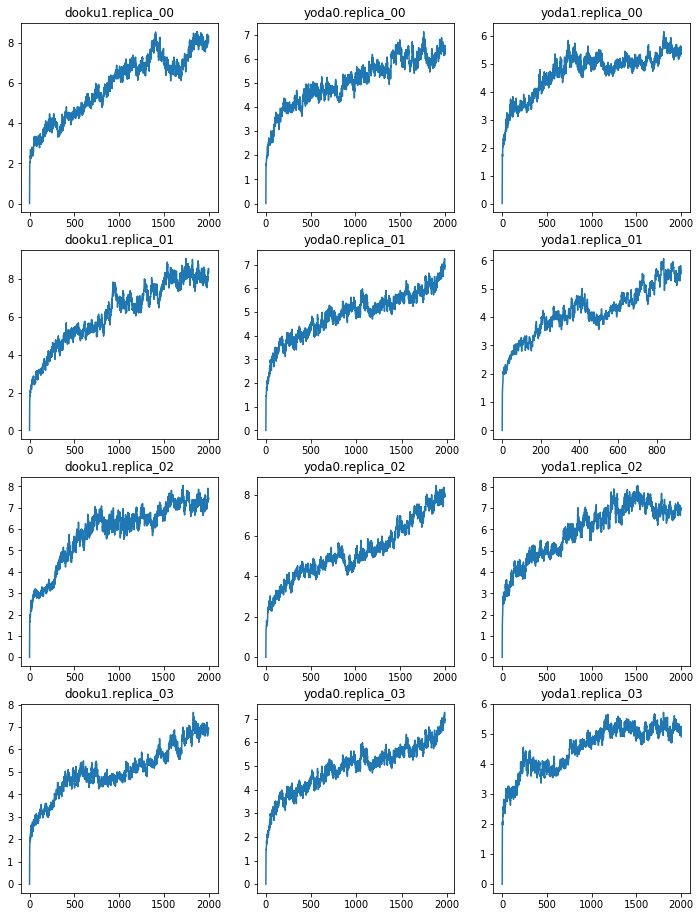

In [13]:
fig,axs=plt.subplots(len(reps),len(systems))
fig.set_figheight(12.*len(reps)/len(systems))
fig.set_figwidth(12)
rmsdDict={}
for iSys,system in enumerate(systems):
    for iRep,rep in enumerate(reps):
        trajKey='.'.join([system,rep])
        print '--- %s ---'%trajKey
        trajDat=trajDict[trajKey]
        pbar=pt.utils.progress.ProgressBarTrajectory(traj=trajDat,style='tqdm')
        rmsdDat=pt.rmsd(pbar,'@CA')
        ax=axs[iRep][iSys]
        ax.plot(rmsdDat)
        ax.set_title(trajKey)
plt.show()

# Backbone Dihedral extraction
We can now compute phi-psi data...
unfortunately, the resulting data tables end up being 300+ M per trajectory.

This means each trajectory should be saved in about 16 chunks, or about 125 frames per chunk.

## Piecewise saving routine
Below, we first define a small function that will allow us to save large dataframes in smaller chunks, splitting over rows.

In [23]:
def saveDataFrameChunks(filePathBase,datTab,rowsPerFile):
    nChunks=int(np.ceil(1.*datTab.shape[0]/rowsPerFile))
    chunkStr='chunk_%s0%gg'%('%',int(np.floor(np.log10(nChunks)))+1)
    with tqdm.tqdm_notebook(np.arange(nChunks)) as saveBar:
        saveBar.set_description('Saving Chunk')
        for iChunk in saveBar:
            chunkStart=iChunk*framesPerFile
            chunkEnd=np.min([(iChunk+1)*framesPerFile,datTab.shape[0]])
            chunkTab=datTab[chunkStart:chunkEnd]
            outFilePath='.'.join([filePathBase,
                                  chunkStr%(iChunk),
                                  'csv'])
            chunkTab.to_csv(outFilePath,index=False)

## extract phi-psi data
We are now ready to extract the phi-psi data from each trajectory.
Pytraj makes this relatively straight-forward and even provides a keyword which 
allows output to be automatically formatted into a pandas data frame.

All we need to do, then, is to add some meta data columns to indicate which trajectory
each data set came from and then save each data set.

As noted above, they are too large to be directly saved in github, so we need to break
them into pieces.

In [63]:
phiPsiTables=[]
outDir='dataFiles/phiPsiTables'
framesPerFile=125
for trajKey in trajDict:
    print '--- %s ---'%trajKey
    print 'Computing Dihedrals'
    pbar=pt.utils.progress.ProgressBarTrajectory(
        traj=trajDict[trajKey],style='tqdm')
    phiPsiTab=pt.multidihedral(pbar,dihedral_types='phi psi',
                               resrange='1-4254',dtype='dataframe')
    print 'Adding trajectory meta-data columns'
    datCols=np.array(phiPsiTab.columns,dtype=str)
    phiPsiTab['Frame']=np.arange(phiPsiTab.shape[0])
    phiPsiTab['System']=trajKey.split('.')[0]
    phiPsiTab['Replica']=trajKey.split('.')[1]
    phiPsiTab=phiPsiTab[np.concatenate([
        ['System','Replica','Frame'],
        datCols])]
    nChunks=int(np.ceil(1.*phiPsiTab.shape[0]/framesPerFile))
    chunkStr='chunk_%s0%gg'%('%',int(np.floor(np.log10(nChunks)))+1)
    print 'Saving to disk in %g chunks'%nChunks
    outFileNameBase='.'.join([trajKey,'phi_psi_table'])
    outFilePathBase='/'.join([outDir,outFileNameBase])
    saveDataFrameChunks(outFilePathBase,
                        phiPsiTab,framesPerFile)
    phiPsiTables.append(copy.deepcopy(phiPsiTab))
    gc.collect()

print '--- --- ---'
print 'Compiling joint data table'
phiPsiTab=pd.concat(phiPsiTables)
print 'Saving to disk in %g chunks'%nChunks
outFileNameBase='.'.join(['joint',
                          'phi_psi_table'])
outFilePathBase='/'.join([outDir,outFileNameBase])
saveDataFrameChunks(outFilePathBase,
                    phiPsiTab,framesPerFile)

print "--- DONE ---"
phiPsiTab.head()

--- dooku1.replica_01 ---
Computing Dihedrals



Adding trajectory meta-data columns
Saving to disk in 17 chunks



--- dooku1.replica_00 ---
Computing Dihedrals



Adding trajectory meta-data columns
Saving to disk in 17 chunks



--- dooku1.replica_03 ---
Computing Dihedrals



Adding trajectory meta-data columns
Saving to disk in 17 chunks



--- dooku1.replica_02 ---
Computing Dihedrals



Adding trajectory meta-data columns
Saving to disk in 17 chunks



--- yoda1.replica_03 ---
Computing Dihedrals



Adding trajectory meta-data columns
Saving to disk in 17 chunks



--- yoda1.replica_02 ---
Computing Dihedrals



Adding trajectory meta-data columns
Saving to disk in 17 chunks



--- yoda1.replica_01 ---
Computing Dihedrals



Adding trajectory meta-data columns
Saving to disk in 8 chunks



--- yoda1.replica_00 ---
Computing Dihedrals



Adding trajectory meta-data columns
Saving to disk in 17 chunks



--- yoda0.replica_00 ---
Computing Dihedrals



Adding trajectory meta-data columns
Saving to disk in 17 chunks



--- yoda0.replica_01 ---
Computing Dihedrals



Adding trajectory meta-data columns
Saving to disk in 16 chunks



--- yoda0.replica_02 ---
Computing Dihedrals



Adding trajectory meta-data columns
Saving to disk in 17 chunks



--- yoda0.replica_03 ---
Computing Dihedrals



Adding trajectory meta-data columns
Saving to disk in 16 chunks



--- --- ---
Compiling joint data table
Saving to disk in 16 chunks



--- DONE ---


,System,Replica,Frame,psi_1,phi_2,psi_2,phi_3,psi_3,phi_4,psi_4,...,psi_4249,phi_4250,psi_4250,phi_4251,psi_4251,phi_4252,psi_4252,phi_4253,psi_4253,phi_4254
0,dooku1,replica_01,0,-74.643320,-86.949338,-11.948323,-51.579987,-48.787006,-66.901503,-61.455534,...,-55.481505,-36.504965,-56.287306,-67.778789,-46.117579,-52.189006,-43.945274,-74.924682,-66.217169,-103.713370
1,dooku1,replica_01,1,-58.206487,-60.224124,-27.677685,-35.367547,-42.186970,-57.895262,-45.374696,...,-53.570610,-58.357301,-46.528847,-60.128773,-45.456034,-55.007758,-57.293026,-69.724111,-64.112041,-110.977059
2,dooku1,replica_01,2,-76.499336,-67.394422,-31.102480,-54.670125,-56.224834,-73.960017,-32.896219,...,-82.908174,-32.453594,-50.303473,-74.339279,-31.088671,-84.192947,-47.148351,-50.825231,-61.616256,-103.934319
3,dooku1,replica_01,3,-73.010182,-64.927090,-5.299644,-69.247831,-53.201987,-62.592633,-48.660764,...,-51.785226,-43.079281,-60.937571,-62.083156,-43.464471,-59.039981,-36.750100,-74.121166,-61.006412,-111.332966
4,dooku1,replica_01,4,-42.996691,-54.061560,-48.147955,-58.139673,-39.149352,-61.645541,-50.066992,...,-50.549270,-45.642865,-54.743022,-66.699957,-41.649581,-44.026032,-71.837834,-69.414632,-60.253487,-108.970518


Now lets repeat this for the membrane simulations.
At present only one replica is present for each lipid mixture.
All three contain POPC in both leaflets, however, POPS and PIP2
contain 10% of the corresponding lipid type in the lower leaflet

Those charged lipid types are known to induce greater opening frequency
in Piezo, so their effect should be observable in the protein dynamics.

## Load Lipid trajectory data

In [18]:
trajBaseDir='trajData/Full_Model'
topFileName='topology.memb_prot.nochamber.parm7'
trajFileName='memb_prot.dcd'

systems=["POPC","PIP2","POPS"]

sysDirStr='wt_memb_%s'

trajDict={}
for system in tqdm.tqdm_notebook(systems):
    sysDir='/'.join([trajBaseDir,sysDirStr%system])
    topFilePath='/'.join([sysDir,topFileName])
    trajKey='.'.join([system])
    print '--- loading %s ---'%trajKey
    trajDir='/'.join([sysDir])
    trajFilePath='/'.join([trajDir,trajFileName])
    print "-Topology path: %s"%topFilePath
    print "-Trajectory path: %s"%trajFilePath
    trajDict[trajKey]=pt.iterload(trajFilePath,top=topFilePath)
    print trajDict[trajKey]
    
print trajDict

--- loading POPC ---
-Topology path: trajData/Full_Model/wt_memb_POPC/topology.memb_prot.nochamber.parm7
-Trajectory path: trajData/Full_Model/wt_memb_POPC/memb_prot.dcd
pytraj.TrajectoryIterator, 2001 frames: 
Size: 10.000000 (GB)
<Topology: 227880 atoms, 5430 residues, 1188 mols, PBC with box type = ortho>
           
--- loading PIP2 ---
-Topology path: trajData/Full_Model/wt_memb_PIP2/topology.memb_prot.nochamber.parm7
-Trajectory path: trajData/Full_Model/wt_memb_PIP2/memb_prot.dcd
pytraj.TrajectoryIterator, 1592 frames: 
Size: 8.000000 (GB)
<Topology: 243780 atoms, 5544 residues, 1302 mols, PBC with box type = ortho>
           
--- loading POPS ---
-Topology path: trajData/Full_Model/wt_memb_POPS/topology.memb_prot.nochamber.parm7
-Trajectory path: trajData/Full_Model/wt_memb_POPS/memb_prot.dcd
pytraj.TrajectoryIterator, 1592 frames: 
Size: 8.000000 (GB)
<Topology: 241272 atoms, 5536 residues, 1294 mols, PBC with box type = ortho>
           

{'POPC': pytraj.TrajectoryIterator,

Now lets check RMSD

Computing RMSD for POPC


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Computing RMSD for POPS


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Computing RMSD for PIP2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

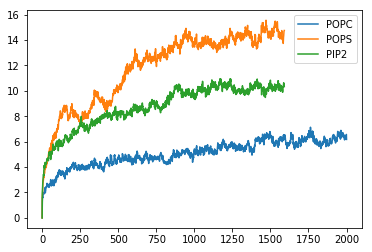

In [21]:
rmsdDict={}
for trajKey in trajDict:
    print "Computing RMSD for %s"%trajKey
    pbar=pt.utils.progress.ProgressBarTrajectory(trajDict[trajKey])
    rmsdDict[trajKey]=pt.rmsd(pbar,'@CA')
    plt.plot(rmsdDict[trajKey],label=trajKey)
plt.legend()
plt.show()

One curious thing to note here is that POPS actually seems to induce the most significant change
in structure. This is curious because it actually has a lower net charge (-2 for POPS) than PIP2 (-4).
The working hypothesis at the time of running these simulations is that these charged lipids are
interacting with positively charged regions of Piezo. It is interesting, then, that the less
charged lipid seems to be inducing the more significant change in protein structure.

Lets extract the phi-psi angles now.

In [24]:
phiPsiTables=[]
outDir='dataFiles/phiPsiTables'
framesPerFile=125
for trajKey in trajDict:
    print '--- %s ---'%trajKey
    print 'Computing Dihedrals'
    pbar=pt.utils.progress.ProgressBarTrajectory(
        traj=trajDict[trajKey],style='tqdm')
    phiPsiTab=pt.multidihedral(pbar,dihedral_types='phi psi',
                               resrange='1-4254',dtype='dataframe')
    print 'Adding trajectory meta-data columns'
    datCols=np.array(phiPsiTab.columns,dtype=str)
    phiPsiTab['Frame']=np.arange(phiPsiTab.shape[0])
    phiPsiTab['System']=trajKey
    phiPsiTab=phiPsiTab[np.concatenate([
        ['System','Frame'],
        datCols])]
    nChunks=int(np.ceil(1.*phiPsiTab.shape[0]/framesPerFile))
    chunkStr='chunk_%s0%gg'%('%',int(np.floor(np.log10(nChunks)))+1)
    print 'Saving to disk in %g chunks'%nChunks
    outFileNameBase='.'.join([trajKey,'phi_psi_table'])
    outFilePathBase='/'.join([outDir,outFileNameBase])
    saveDataFrameChunks(outFilePathBase,
                        phiPsiTab,framesPerFile)
    phiPsiTables.append(copy.deepcopy(phiPsiTab))
    gc.collect()

print '--- --- ---'
print 'Compiling joint data table'
phiPsiTab=pd.concat(phiPsiTables)
print 'Saving to disk in %g chunks'%nChunks
outFileNameBase='.'.join(['joint_memb',
                          'phi_psi_table'])
outFilePathBase='/'.join([outDir,outFileNameBase])
saveDataFrameChunks(outFilePathBase,
                    phiPsiTab,framesPerFile)

print "--- DONE ---"
phiPsiTab.head()

--- POPC ---
Computing Dihedrals



Adding trajectory meta-data columns
Saving to disk in 17 chunks



--- POPS ---
Computing Dihedrals



Adding trajectory meta-data columns
Saving to disk in 13 chunks



--- PIP2 ---
Computing Dihedrals



Adding trajectory meta-data columns
Saving to disk in 13 chunks



--- --- ---
Compiling joint data table
Saving to disk in 13 chunks



--- DONE ---


,System,Frame,psi_1,phi_2,psi_2,phi_3,psi_3,phi_4,psi_4,phi_5,...,psi_4249,phi_4250,psi_4250,phi_4251,psi_4251,phi_4252,psi_4252,phi_4253,psi_4253,phi_4254
0,POPC,0,-92.538319,-90.675970,50.467890,-83.536252,-56.646704,-66.994656,-43.655675,-48.537961,...,-45.001072,-51.833152,-49.188380,-81.741315,-5.315496,-82.160726,-80.366564,-54.248897,-57.795869,-103.283576
1,POPC,1,-67.897299,-87.968510,80.827211,-84.977793,-53.473650,-67.267185,-21.730216,-73.346152,...,-57.252846,-47.089584,-56.609321,-51.742248,-42.113380,-67.250609,-62.100206,-79.930780,-63.703503,-88.860026
2,POPC,2,-54.649079,-77.358751,105.068599,-86.017091,-75.500165,-66.551154,-40.604271,-70.945980,...,-39.616951,-51.222322,-59.783692,-64.687987,-25.811014,-81.296024,-35.502232,-90.227413,-45.320649,-101.483824
3,POPC,3,-53.227823,-62.547584,65.871080,-69.612892,-49.677393,-56.152612,-45.944265,-70.275168,...,-58.491646,-41.057612,-45.783047,-73.580293,-48.073389,-60.708680,-52.913657,-78.880614,-48.355414,-108.382543
4,POPC,4,-44.386791,-75.632470,78.984520,-65.249080,-56.598326,-44.975400,-44.357276,-76.498243,...,-55.192075,-52.667300,-42.970486,-76.748131,-51.178906,-55.404238,-48.370952,-87.449109,-52.053732,-104.899646
